In [1]:
from numpy import random
from IPython.display import clear_output
import time
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation

In [2]:
def con_run(frame_n = 100,
            start_pop = 50,
            xd = 10,
            yd = 10,
            sample_n = 100,
            top_fraction = 0.1):
    
    ffs = []
    scores = []
    top_n = int(sample_n/top_fraction)
    
    for i in range(top_n):
    
        c = np.append(random.choice(xd*3,start_pop),random.choice(yd*3,start_pop)).reshape(start_pop,2)
        a = np.repeat(0,xd*yd*3*3).reshape([xd*3,yd*3])
        for i in range(start_pop):
            a[c[i][0],c[i][1]] = 1

        for i in range(frame_n-1):
            b = life_step(a.reshape([i+1,xd*3, yd*3])[i,:]).flatten()
            a = np.append(a,b)

        a = a.reshape(frame_n, xd*3, yd*3)

        score = (frame_n*xd*yd*3*3)/np.sum(a) * np.var(a.reshape([frame_n*xd*yd*3*3]), axis=0)

        ffs = np.append(ffs,a[0].flatten())
        scores = np.append(scores,score)
        
    top = np.argsort(scores)[::-1][:sample_n]
    top_scores = scores[top]
    top_ffs = ffs.reshape([top_n,xd*yd*3*3])[top]

    return(top_ffs,top_scores)

In [3]:
def life_step(X):
    """Game of life step using generator expressions"""
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

In [4]:
def life_animation(X, dpi=80, frames=10, interval=300, mode='loop'):
    
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(int)
    
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 10. / dpi, X.shape[0] * 10. / dpi)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(-0.05, 10)
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(X_blank)
        return (im,)
    
    # animation function.  This is called sequentially
    def animate(i):
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        return (im,)
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval)
    
    return display_animation(anim, default_mode=mode)      

In [5]:
def sig_func(x,y):
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [6]:
def train_des(des_training_inputs,
              des_training_outputs,
              des_weights,
              iteration_n):
    
    for i in range(iteration_n):
        result = sig_func(des_training_inputs, des_weights)
        des_weights += np.dot(des_training_inputs.T, (des_training_outputs - result) * result * (1 - result))
        
    return(des_weights)

In [7]:
def train_gen(gen_noise,
              gen_weights,
              des_weights,
              iteration_n):
    
    for i in range(iteration_n):
        generated = sig_func(gen_noise, gen_weights)
        result = sig_func(generated, des_weights)
        top = np.argsort(result.flatten())[::-1][:top_n]
        bottom = np.argsort(result.flatten())[:top_n]
        gen_weights += np.dot(gen_noise[top].T, (generated[top] - generated[bottom]) * generated[bottom] * (1 - generated[bottom]))

    return(gen_weights)

In [8]:
iteration_n = 10000
passes = 1
nrows = 100
top_n = 50
sample_n = 100
xd = 10
yd = 10
frame_n = 100

des_td = con_run(frame_n = 100,
                 start_pop = 50,
                 xd = xd,
                 yd = yd,
                 sample_n = sample_n,
                 top_fraction = 0.1)

des_training_inputs = des_td[0]

des_training_outputs = des_td[1].reshape(sample_n,1)

des_weights = 2 * random.random((des_training_inputs.shape[1], des_training_outputs.shape[1])) - 1

gen_noise = random.choice([0,1], [nrows, des_training_inputs.shape[1]])

In [9]:
for i in range(passes):

    gen_weights = 2 * random.random((des_training_inputs.shape[1], des_training_inputs.shape[1])) - 1
    
    des_weights = train_des(des_training_inputs,
                            des_training_outputs,
                            des_weights,
                            iteration_n)
    
    gen_weights = train_gen(gen_noise,
                            gen_weights,
                            des_weights,
                            iteration_n)
    
    gen_result = sig_func(gen_noise, gen_weights)

    clear_output(wait=True)
    
    im = np.unique(np.round(gen_result), axis=0)
    score = sig_func(im, des_weights)
    top = np.argsort(score)[::-1][0]
    top_score = score[top]
    top_im = im[top].reshape([xd*3,yd*3])
    
    print(top_im)
    print(top_score)

[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
  0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
  1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
  0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
  1. 1. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.
  1. 1. 0. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.
  1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  1. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 


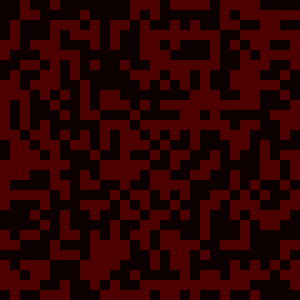
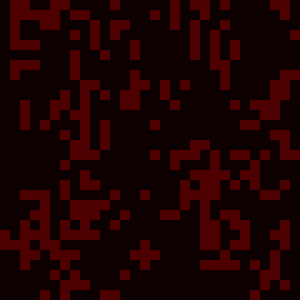
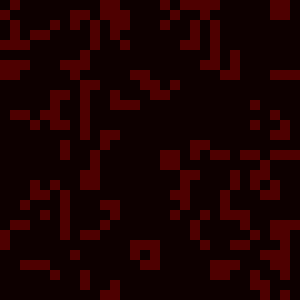
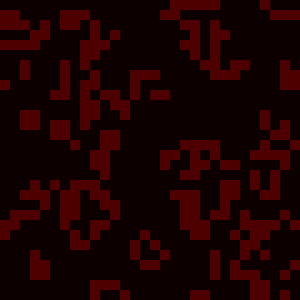
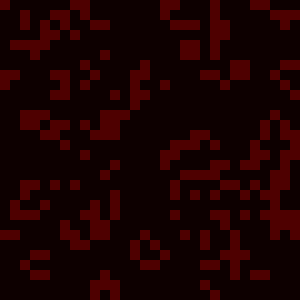
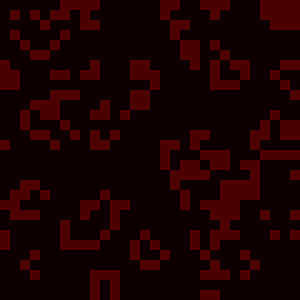
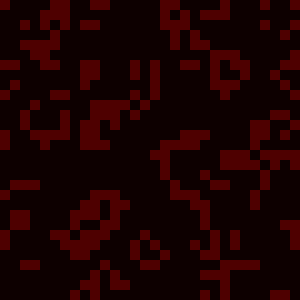
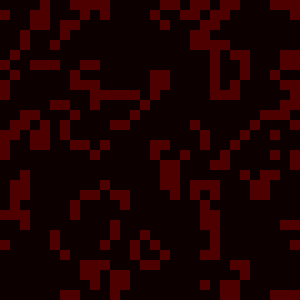
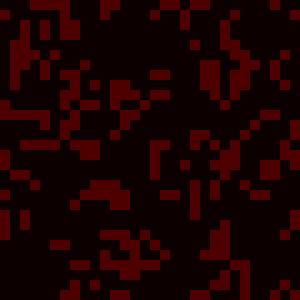
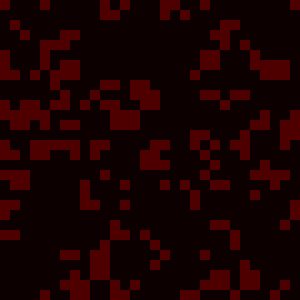
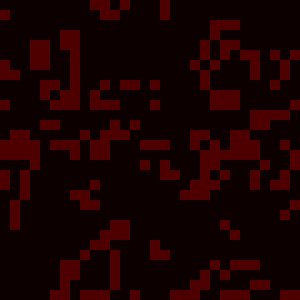
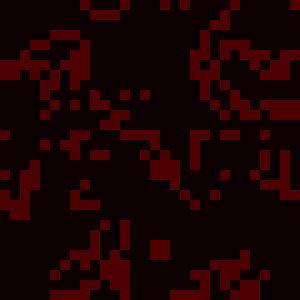
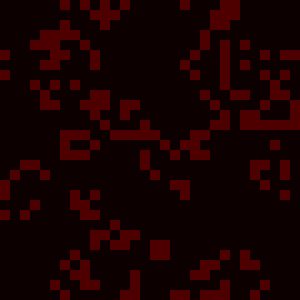
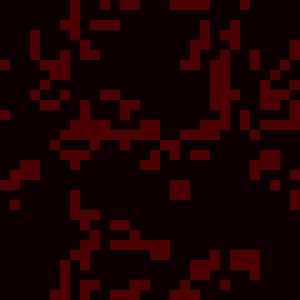
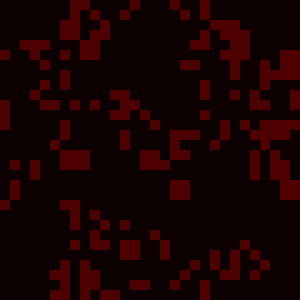
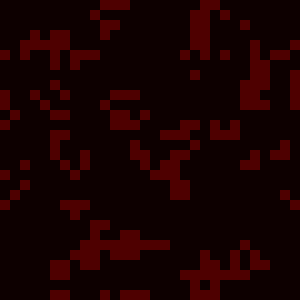
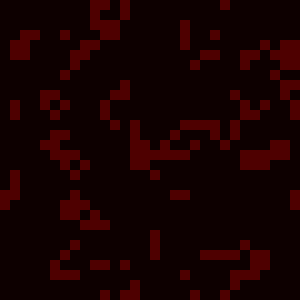
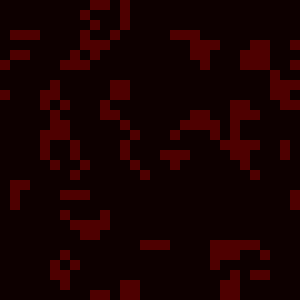
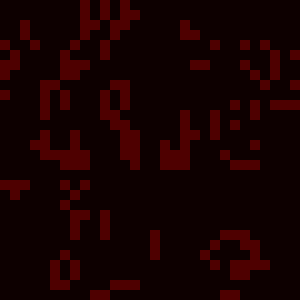
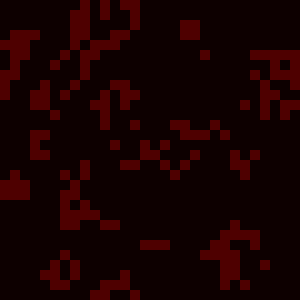
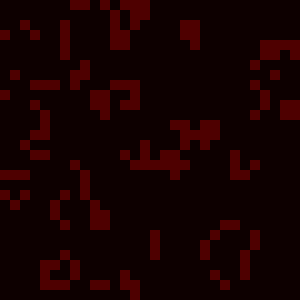
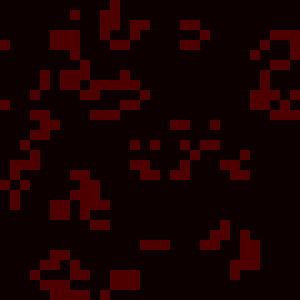
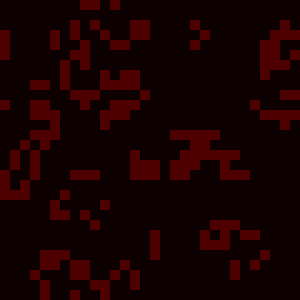
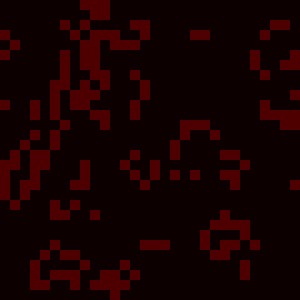
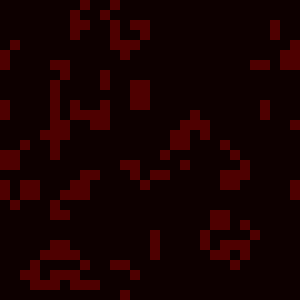
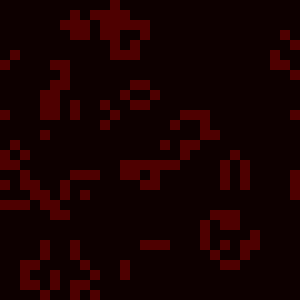
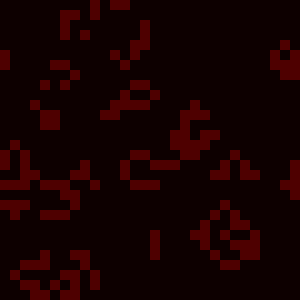
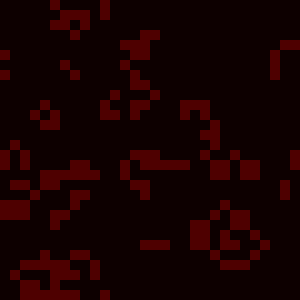
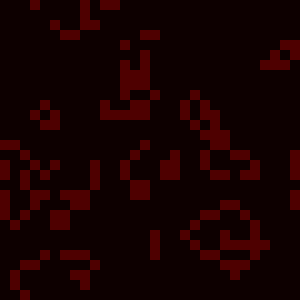
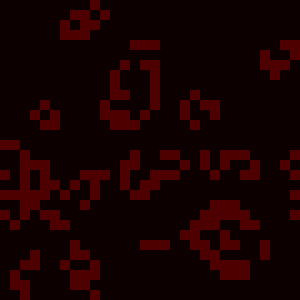
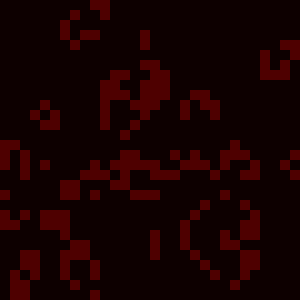
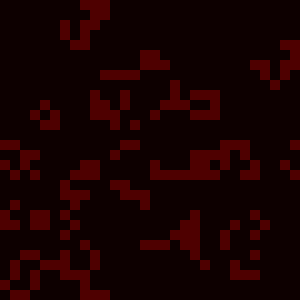
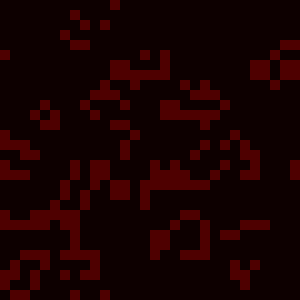
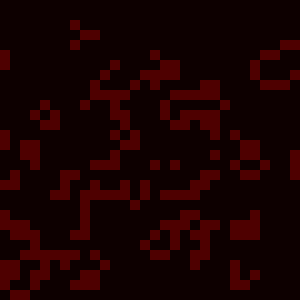
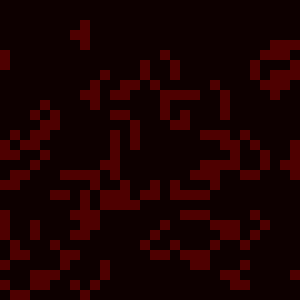
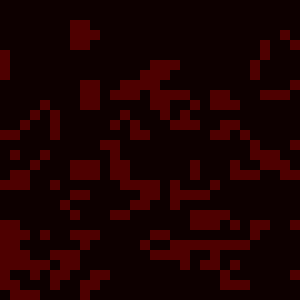
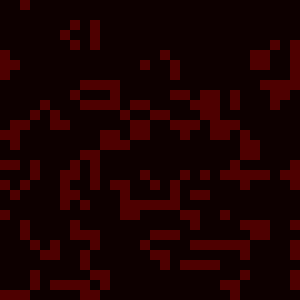
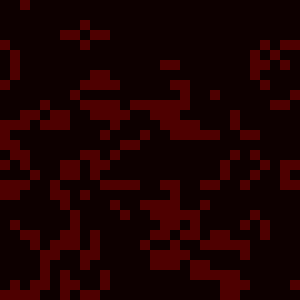
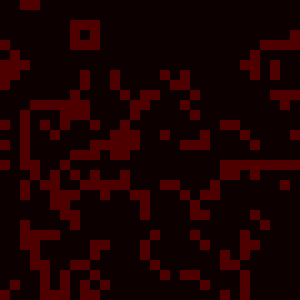
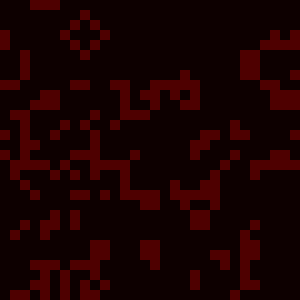
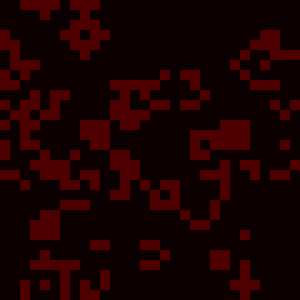
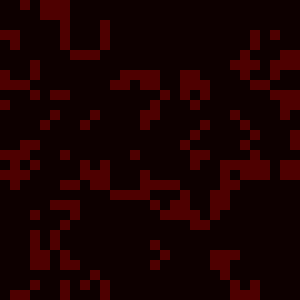
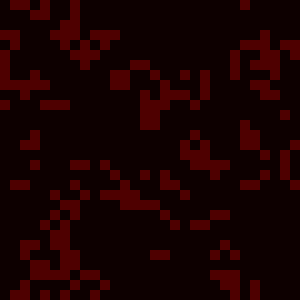
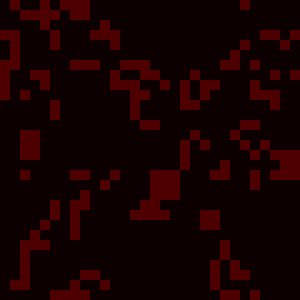
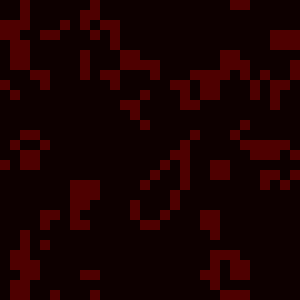
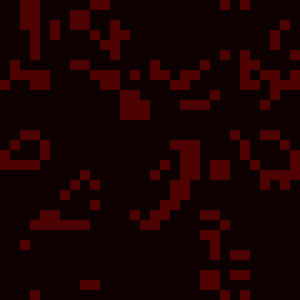
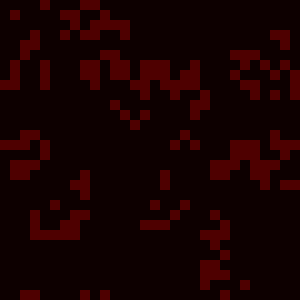
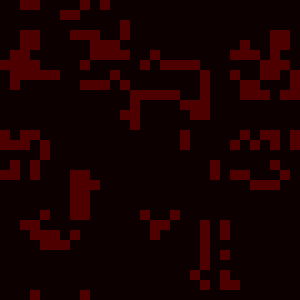
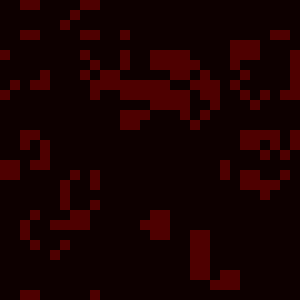
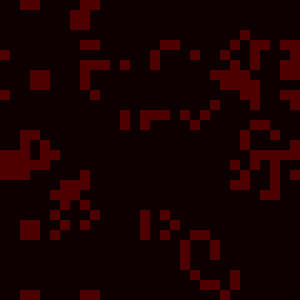
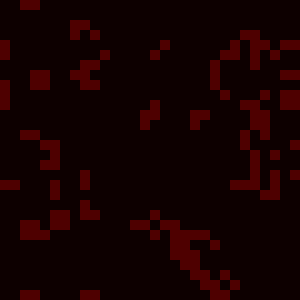
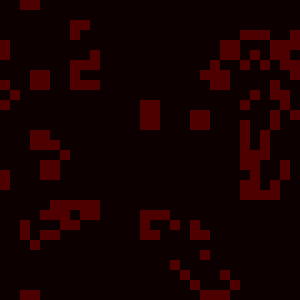
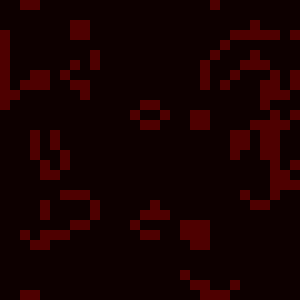
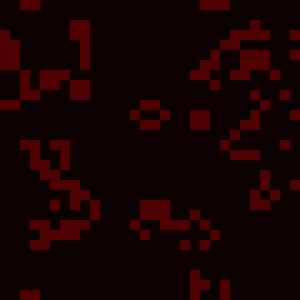
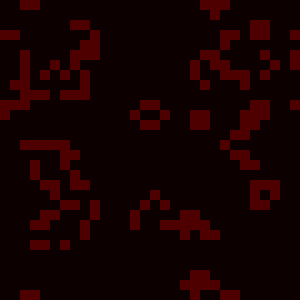
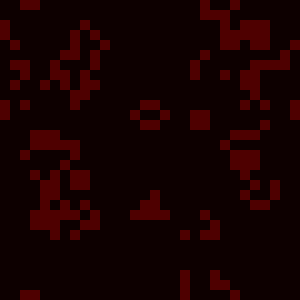
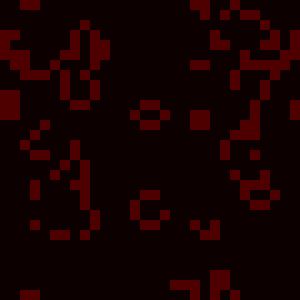
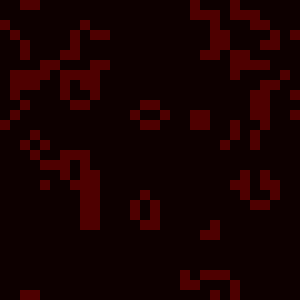
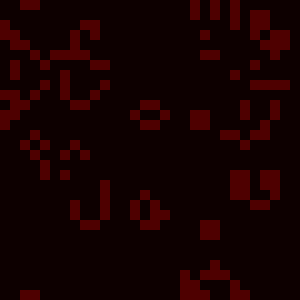
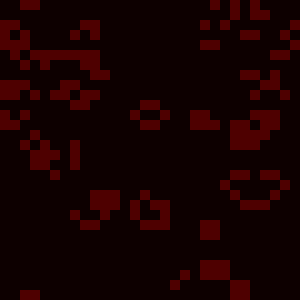
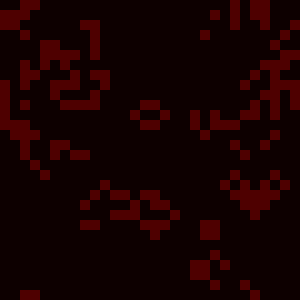
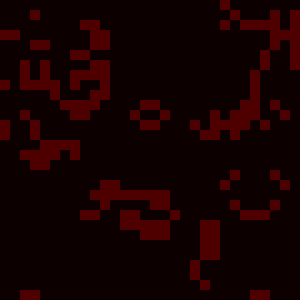
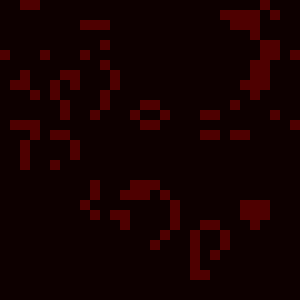
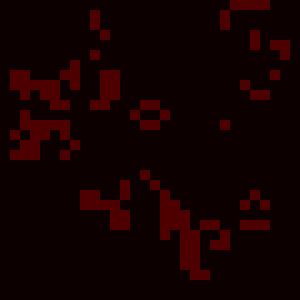
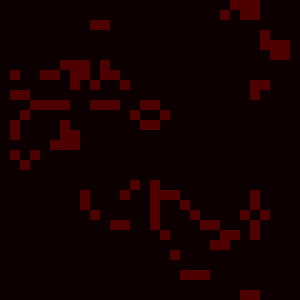
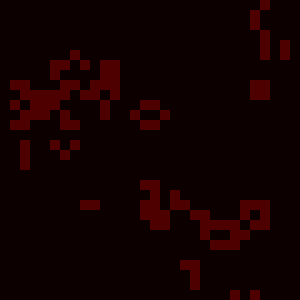
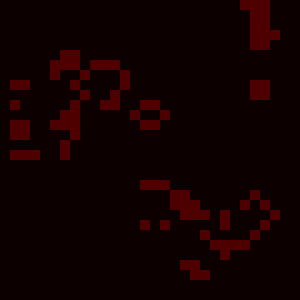
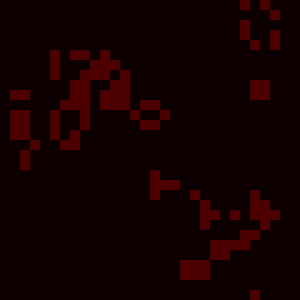
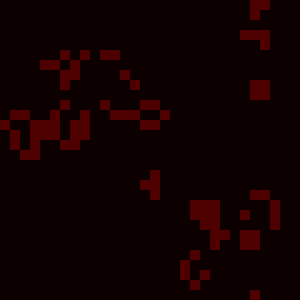
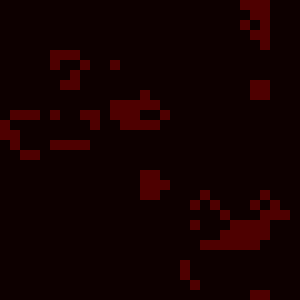
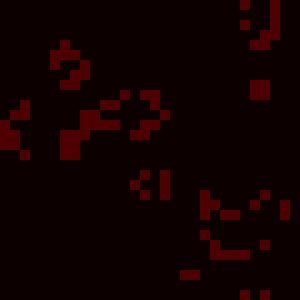
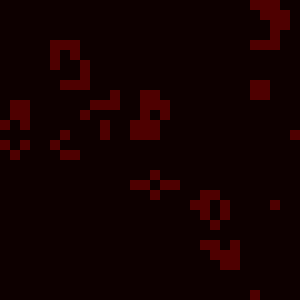
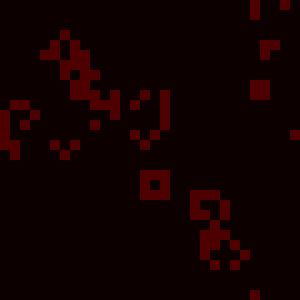
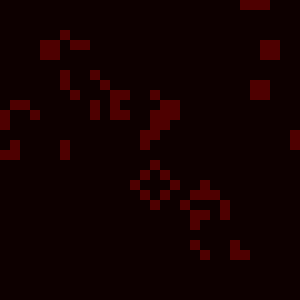
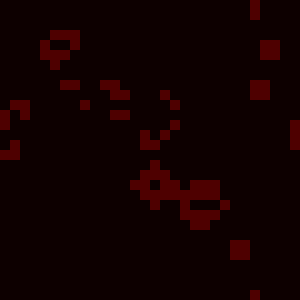
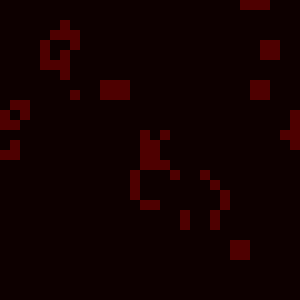
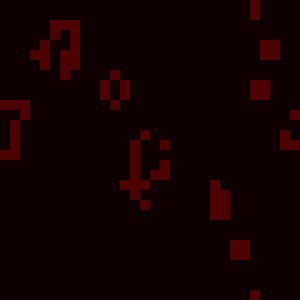
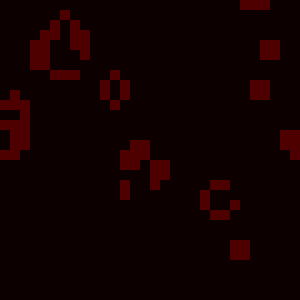
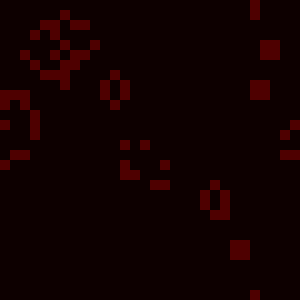
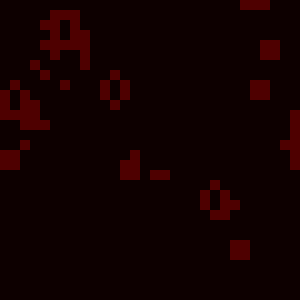
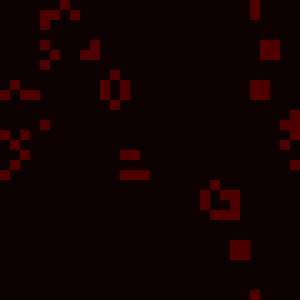
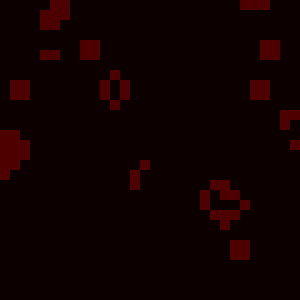
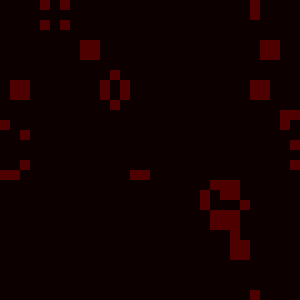
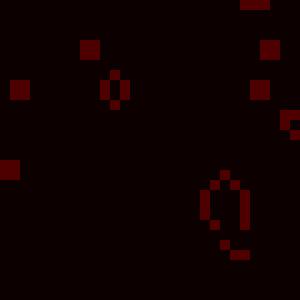
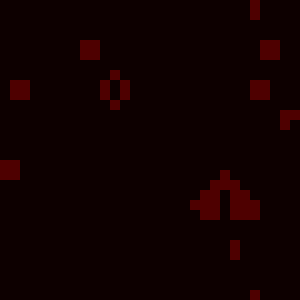
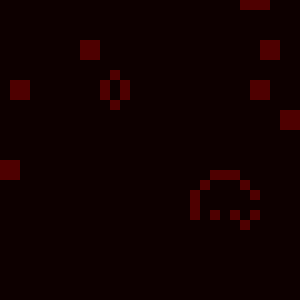
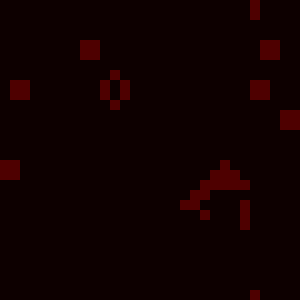
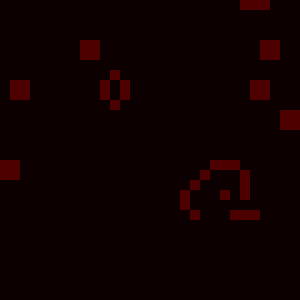
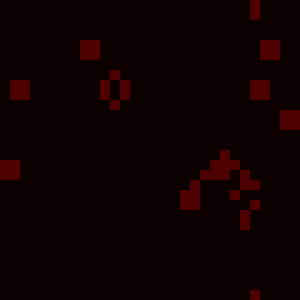
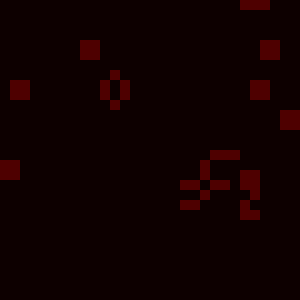
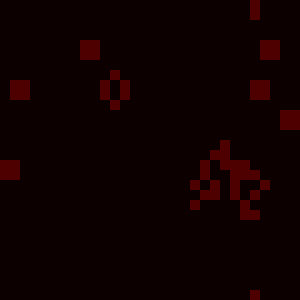
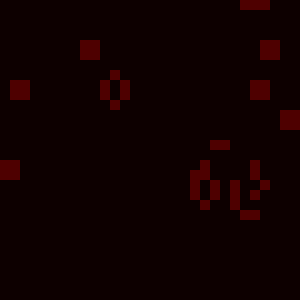
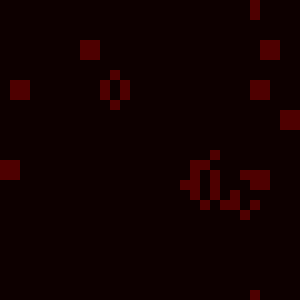
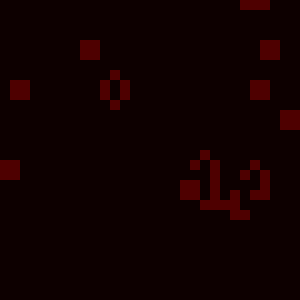
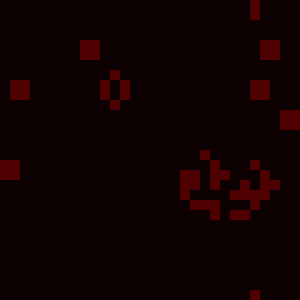
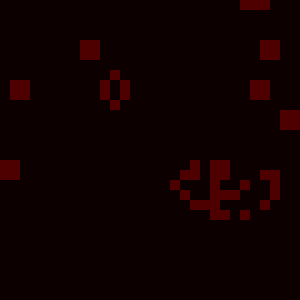
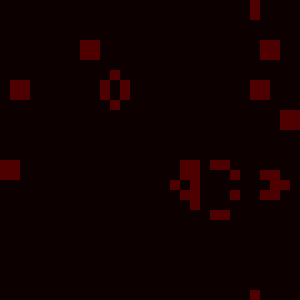
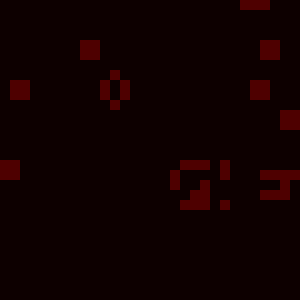
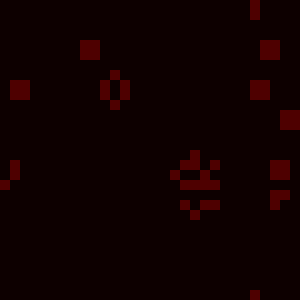
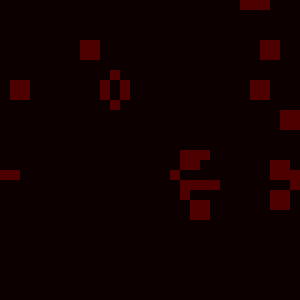

In [10]:
life_animation(top_im, dpi=15, frames=frame_n, interval=50, mode='once')